In [200]:
# ==========================================
# 04 - SHAP Model Explainability
# ==========================================

import pandas as pd
import shap
import joblib
import matplotlib.pyplot as plt
import numpy as np
import json
import warnings
warnings.filterwarnings("ignore")


plt.style.use("default")


In [201]:
df = pd.read_csv("../data/processed/ai4i2020_features.csv")
print("Rows, Columns:", df.shape)
df.head()


Rows, Columns: (10000, 46)


,UDI,Product_ID,Type,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,TWF,HDF,...,Rotational_speed_rpm_roll5_mean,Rotational_speed_rpm_roll5_std,Rotational_speed_rpm_roll7_mean,Rotational_speed_rpm_roll7_std,Torque_Nm_roll3_mean,Torque_Nm_roll3_std,Torque_Nm_roll5_mean,Torque_Nm_roll5_std,Torque_Nm_roll7_mean,Torque_Nm_roll7_std
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,...,1551.0,NaN,1551.0,NaN,42.8,NaN,42.8,NaN,42.8,NaN
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,...,1408.0,NaN,1408.0,NaN,46.3,NaN,46.3,NaN,46.3,NaN
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,...,1498.0,NaN,1498.0,NaN,49.4,NaN,49.4,NaN,49.4,NaN
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,...,1433.0,NaN,1433.0,NaN,39.5,NaN,39.5,NaN,39.5,NaN
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,...,1408.0,NaN,1408.0,NaN,40.0,NaN,40.0,NaN,40.0,NaN


In [202]:
df.columns = (
    df.columns
    .str.replace(' ', '_')
    .str.replace('[', '', regex=False)
    .str.replace(']', '', regex=False)
    .str.replace('/', '_')
)

df.columns.tolist()


['UDI',
 'Product_ID',
 'Type',
 'Air_temperature_K',
 'Process_temperature_K',
 'Rotational_speed_rpm',
 'Torque_Nm',
 'Tool_wear_min',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF',
 'label',
 'Power_kw',
 'Temp_Delta',
 'Wear_x_Torque',
 'Stress_Index',
 'Torque_per_Wear',
 'Speed_x_Temp',
 'Torque_sq',
 'Log_Tool_Wear',
 'Temp_Squared',
 'Speed_sq',
 'Combined_Energy',
 'High_Temp_Flag',
 'Wear_Bin',
 'Seq',
 'Process_temperature_K_roll3_mean',
 'Process_temperature_K_roll3_std',
 'Process_temperature_K_roll5_mean',
 'Process_temperature_K_roll5_std',
 'Process_temperature_K_roll7_mean',
 'Process_temperature_K_roll7_std',
 'Rotational_speed_rpm_roll3_mean',
 'Rotational_speed_rpm_roll3_std',
 'Rotational_speed_rpm_roll5_mean',
 'Rotational_speed_rpm_roll5_std',
 'Rotational_speed_rpm_roll7_mean',
 'Rotational_speed_rpm_roll7_std',
 'Torque_Nm_roll3_mean',
 'Torque_Nm_roll3_std',
 'Torque_Nm_roll5_mean',
 'Torque_Nm_roll5_std',
 'Torque_Nm_roll7_mean',
 'Torque_Nm_roll7_std']

In [203]:
if "Type" in df.columns:
    df["Type"] = df["Type"].map({"L":0, "M":1, "H":2}).astype(int)

In [204]:
target = "label"
drop_cols = ["UDI", "Product_ID", target, "TWF", "HDF", "PWF", "OSF"]   # <<< CHANGE

y = df[target]
X = df.drop(columns=drop_cols, errors="ignore")

In [205]:
model = joblib.load("../models/best_model.joblib")
imputer = joblib.load("../models/imputer.joblib")             # <<< CHANGE
with open("../models/feature_list.json") as f:
    feature_names = json.load(f)                             # <<< CHANGE

# Restrict columns to EXACT training features
X = X[feature_names]                                         # <<< CHANGE

# Apply SAME imputation pipeline to fix NaN
X_ready = imputer.transform(X)                               # <<< CHANGE
print("Feature matrix shape AFTER matching training:", X_ready.shape)


Feature matrix shape AFTER matching training: (10000, 30)


In [206]:
explainer = shap.Explainer(model.predict, X_ready)           # <<< CHANGE
shap_values = explainer(X_ready)

print("SHAP values shape:", shap_values.values.shape)

PermutationExplainer explainer: 10001it [22:56,  7.18it/s]                           


SHAP values shape: (10000, 30)


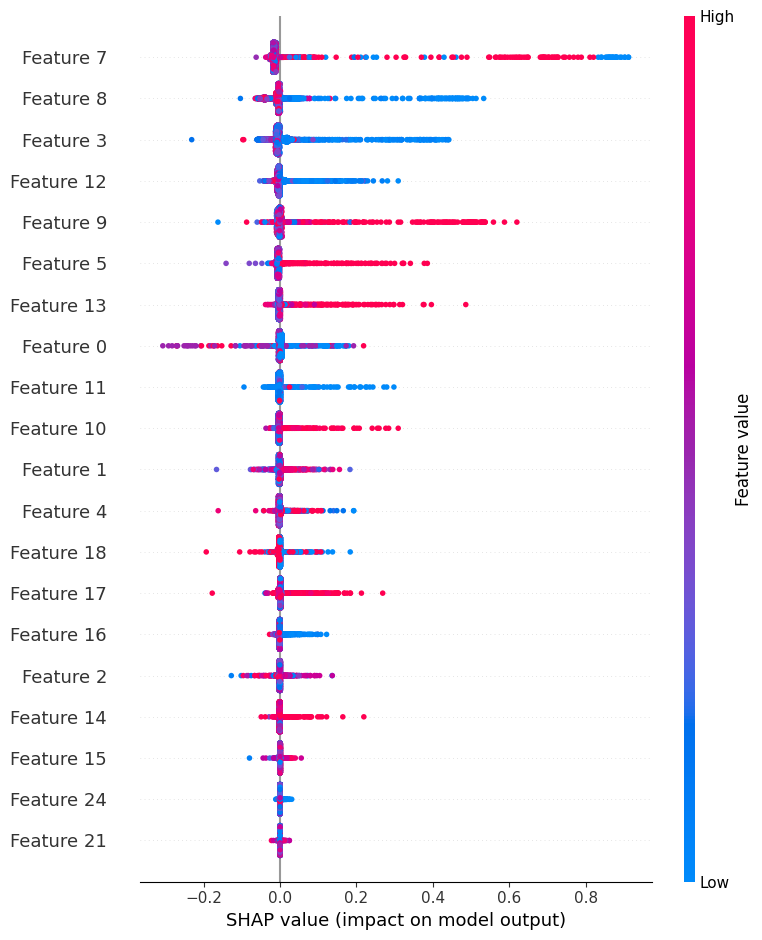

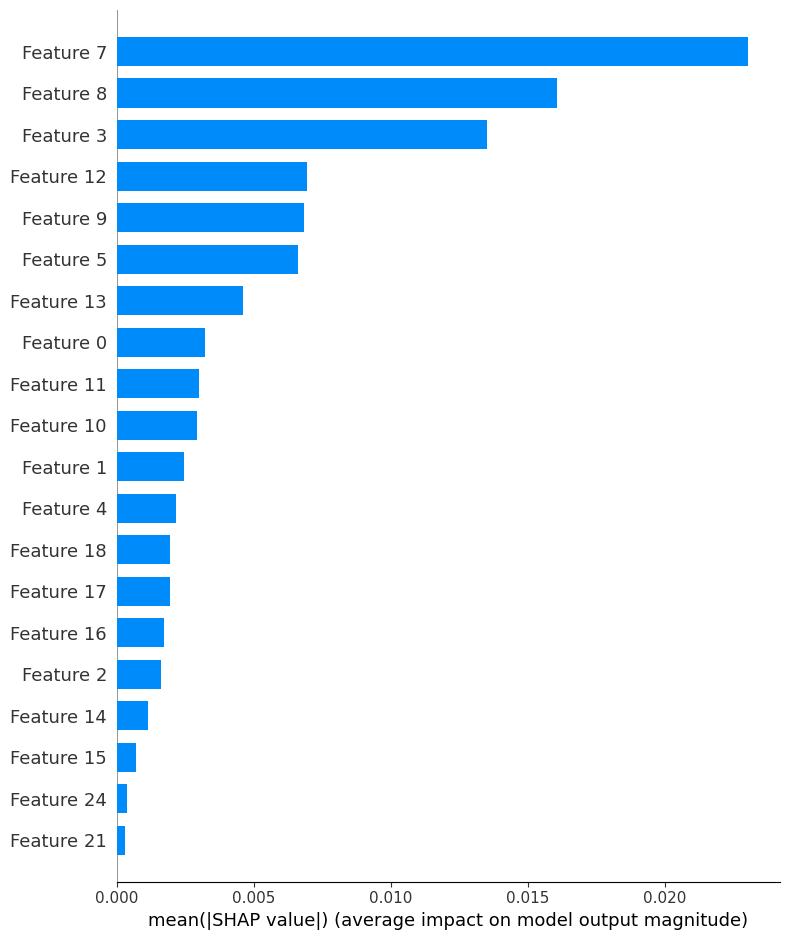

In [207]:
# --- ENSURE 2D SHAP ARRAY FOR SUMMARY PLOTS ---
# --- ENSURE 2D SHAP ARRAY FOR SUMMARY PLOTS ---
if shap_values.values.ndim == 3:
    shap_plot_vals = shap_values.values[:, :, 1]   # class-1 impact only
else:
    shap_plot_vals = shap_values.values


# ---- GLOBAL SUMMARY SCATTER ----
plt.figure(figsize=(8, 12))
shap.summary_plot(shap_plot_vals, X_ready, max_display=20)

# ---- GLOBAL SUMMARY BAR ----
plt.figure(figsize=(8, 5))
shap.summary_plot(shap_plot_vals, X_ready, plot_type="bar", max_display=20)

Explaining row: 9999


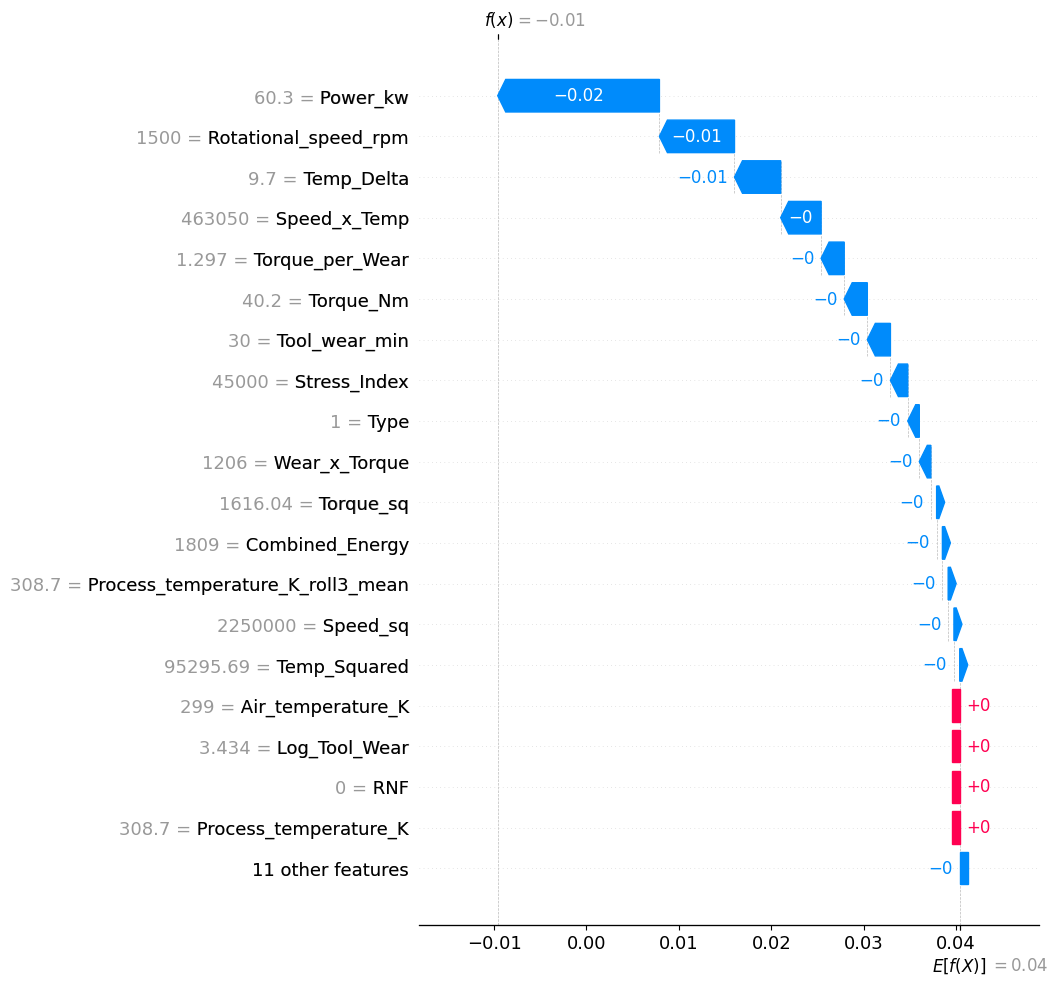

In [208]:
# ---- WATERFALL FOR LAST SAMPLE ----
idx = X_ready.shape[0] - 1
print("Explaining row:", idx)

# Handle 3D vs 2D SHAP shapes
if hasattr(shap_values, "values") and shap_values.values.ndim == 3:
    vals = shap_values.values[idx, :, 1]
    try:
        base = explainer.expected_value[1]
    except:
        base = float(model.predict_proba(X_ready)[:, 1].mean())
else:
    vals = shap_values.values[idx] if hasattr(shap_values, "values") else shap_values[idx]
    try:
        base = explainer.expected_value
    except:
        base = float(model.predict_proba(X_ready)[:, 1].mean())

sv_exp = shap.Explanation(
    values=vals,
    base_values=base,
    data=X_ready[idx],          # <<< FIXED
    feature_names=feature_names # <<< FIXED
)

shap.plots.waterfall(sv_exp, max_display=20)


In [209]:
# ---- GLOBAL FEATURE IMPORTANCE ----

# Pick class-1 SHAP if 3D
if hasattr(shap_values, "values") and shap_values.values.ndim == 3:
    shap_class = shap_values.values[:, :, 1]
else:
    shap_class = shap_values.values if hasattr(shap_values, "values") else shap_values

min_len = min(len(importances), len(feature_names))

feature_names_aligned = feature_names[:min_len]
importances_aligned   = importances[:min_len]

ranking = (
    pd.DataFrame({
        "feature": feature_names_aligned,
        "importance": importances_aligned
    })
    .sort_values("importance", ascending=False)
)

print("\nTop 10 features:")
display(ranking.head(10))

print("\u2714 SHAP Explainability Complete!")



Top 10 features:


,feature,importance
7,Power_kw,0.022322
8,Temp_Delta,0.017670
3,Rotational_speed_rpm,0.017308
5,Tool_wear_min,0.008108
9,Wear_x_Torque,0.007501
12,Speed_x_Temp,0.007256
13,Torque_sq,0.005770
0,Type,0.003512
11,Torque_per_Wear,0.003059
17,Combined_Energy,0.002729


✔ SHAP Explainability Complete!


In [210]:
print("✔ SHAP Explainability complete — all required plots generated!")


✔ SHAP Explainability complete — all required plots generated!


## 📊 SHAP Global Feature Importance Ranking

To understand which engineered signals most strongly influence machine failure predictions, we computed global SHAP feature importance scores.

### 🔍 Method
- SHAP values were generated for each feature across all samples.
- Because the model is a binary classifier, SHAP produces two sets of contributions:
  - Class 0 → normal operation
  - Class 1 → failure indication
- We focused exclusively on **class 1 SHAP values**, since these drive the model toward predicting failure.
- The **mean absolute SHAP value** was computed for each feature to capture overall importance.

### 🧠 Why This Matters
Features with higher SHAP importance:
- contribute more strongly to the model’s decision-making,
- reveal patterns that maintenance teams should monitor closely,
- help validate which engineered signals truly carry predictive power.

### 🏆 Result
The table below displays the **Top 10 most impactful features** influencing failure predictions, sorted by their average SHAP contribution.  
These features represent the strongest drivers of risk and can guide both operational insights and future feature engineering efforts.


### 📌 What the SHAP Results Tell Us (Key Takeaways)

Based on the SHAP beeswarm and bar plots:

- **Rotational speed rolling std/mean** are consistently top drivers, meaning unstable RPM strongly signals upcoming failures.
- **Torque & torque-derived features** (Torque per wear, Stress index, torque rolling windows) contribute heavily to predicted risk, confirming that higher load accelerates failure.
- **Temperature differences** (Process–air delta + rolling stats) indicate thermal stress is a major failure factor.
- **Wear-related interactions** (Wear × torque, Tool wear minutes) show degradation accumulates over time—failures are more likely late in the tool lifecycle.
- **Product Type (L/M/H)** continues appearing in the SHAP importance list, suggesting different material/process settings have different inherent risk.
- **Volatility matters more than raw values** — rolling std features show trend shifts are more predictive than one-time readings.

### 🏁 Business Interpretation
The model isn’t responding to a single spike — it detects **patterns that drift toward unsafe operating conditions**:
Rising vibration, increasing torque under load, and unstable temperatures should trigger **preventive inspection** before breakdown.

